In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [22]:
# === 1. Load Data ===
df = pd.read_csv("solar-measurements_kenya.csv",dtype={'comments': str}) 
df['time'] = pd.to_datetime(df['time'], errors='coerce')
# === Display first few rows ===
print(df.head())

                 time  dhi_pyr  ghi_pyr_1  ghi_pyr_2  air_temperature  \
0 2019-04-12 00:01:00      0.0        0.0        0.0        15.598166   
1 2019-04-12 00:02:00      0.0        0.0        0.0        15.573500   
2 2019-04-12 00:03:00      0.0        0.0        0.0        15.566666   
3 2019-04-12 00:04:00      0.0        0.0        0.0        15.556666   
4 2019-04-12 00:05:00      0.0        0.0        0.0        15.532499   

   relative_humidity  barometric_pressure  precipitation  wind_speed  \
0          97.782997           811.291992            0.0    1.251317   
1          97.705002           811.211609            0.0    1.101517   
2          97.707001           811.216919            0.0    0.602717   
3          97.619003           811.210022            0.0    1.107400   
4          97.594002           811.212647            0.0    0.540367   

   wind_from_direction  gti_clean  gti_soil  gti_monthly  sensor_cleaning  \
0           243.790543        0.0       0.0        

In [25]:
# === 2. Feature Engineering ===
df['hour'] = df['time'].dt.hour
df['dayofyear'] = df['time'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

In [26]:
# === 3. Define Features and Target ===
features = [
    'ghi_pyr_1', 'ghi_pyr_2', 'dhi_pyr', 'air_temperature',
    'relative_humidity', 'barometric_pressure', 'precipitation',
    'wind_speed', 'wind_from_direction',
    'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos'
]
target = 'gti_clean'

In [28]:
# === 4. Prepare Data ===
df_model = df[features + [target]].dropna()
df_sampled = resample(df_model, n_samples=10000, random_state=42)
# === View few rows of the sampled dataframe ===
print(df_sampled.head())

         ghi_pyr_1   ghi_pyr_2     dhi_pyr  air_temperature  \
397021  130.030884  127.603348  125.792412        17.643166   
447852    0.000000    0.000000    0.000000        13.712832   
406995  760.361633  758.968811  291.716370        21.065832   
351395    0.000000    0.000000    0.000000        13.764666   
394942    0.000000    0.000000    0.000000        11.675666   

        relative_humidity  barometric_pressure  precipitation  wind_speed  \
397021          77.515999           811.353699            0.0    3.527000   
447852          79.054001           811.804138            0.0    1.553667   
406995          58.449001           810.318176            0.0    6.953667   
351395          67.953003           813.941223            0.0    5.367000   
394942          87.505997           812.303955            0.0    4.313666   

        wind_from_direction  hour_sin      hour_cos  dayofyear_sin  \
397021            97.474884 -0.965926 -2.588190e-01       0.988678   
447852           2

In [8]:
X = df_sampled[features]
y = df_sampled[target]

In [9]:
# === 5. Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# === 6. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [11]:
# === 7. Train Model ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# === 8. Predict and Evaluate ===
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [13]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 8.64
RMSE: 17.74
R² Score: 0.9975


In [14]:
# === 9. Save Model and Scaler ===
joblib.dump(model, "solar_prediction_model.pkl")
joblib.dump(scaler, "solar_scaler.pkl")

['solar_scaler.pkl']

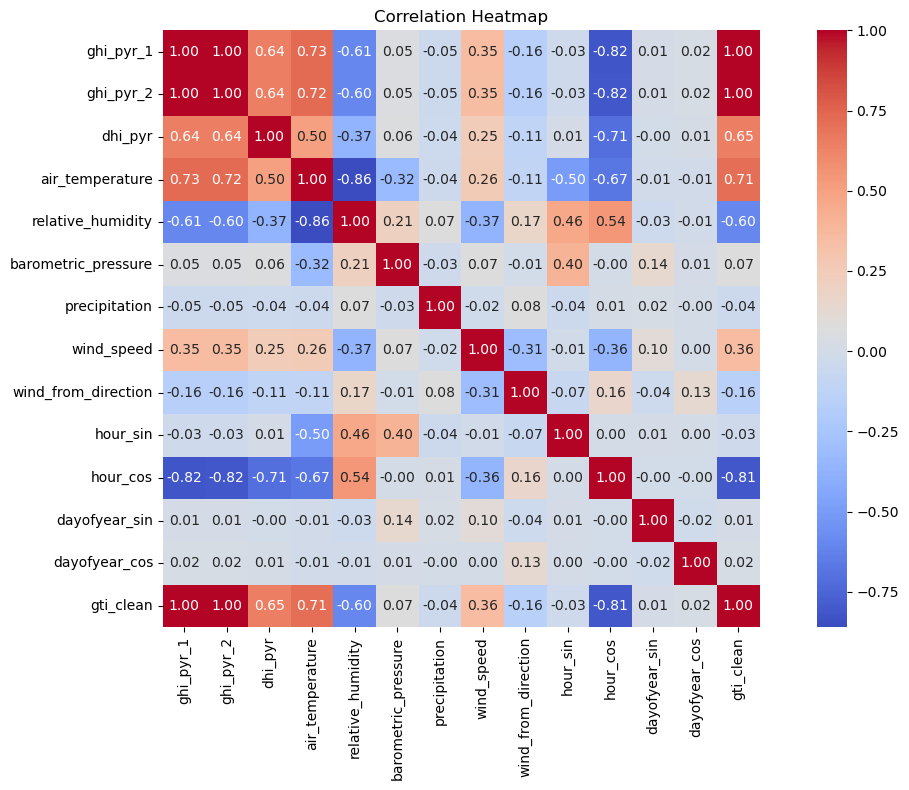

In [15]:
# === 10. Correlation Heatmap ===
plt.figure(figsize=(12, 8))
corr = df_sampled[features + [target]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

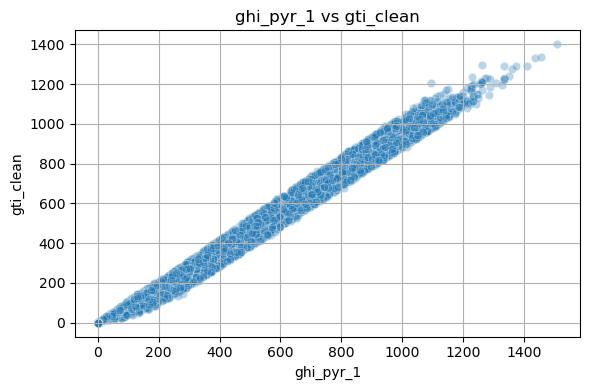

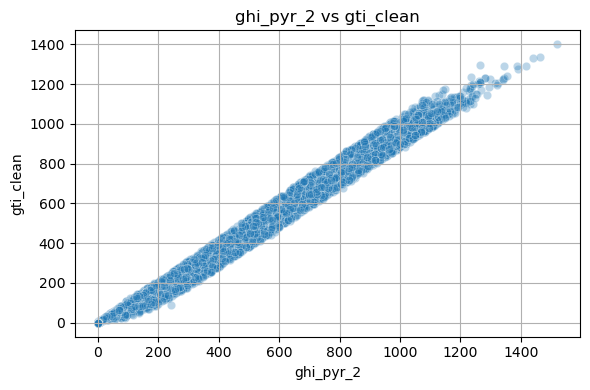

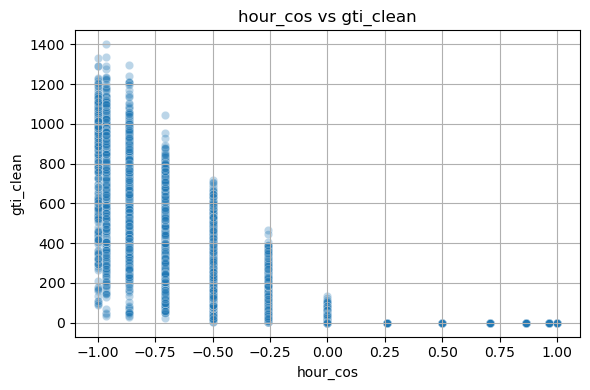

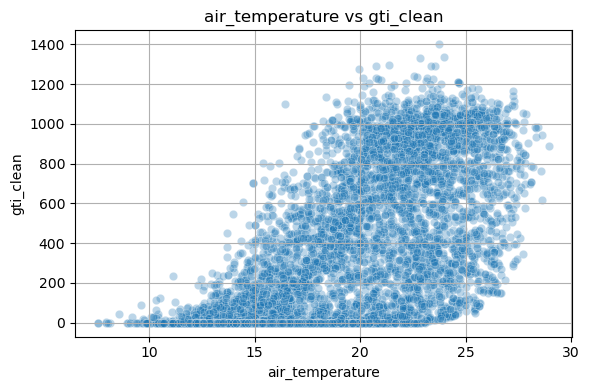

In [16]:
# === 11. Scatter Plots for Top Features ===
top_corr = corr[target].abs().sort_values(ascending=False)[1:5].index
for feature in top_corr:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_sampled, x=feature, y=target, alpha=0.3)
    plt.title(f"{feature} vs {target}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

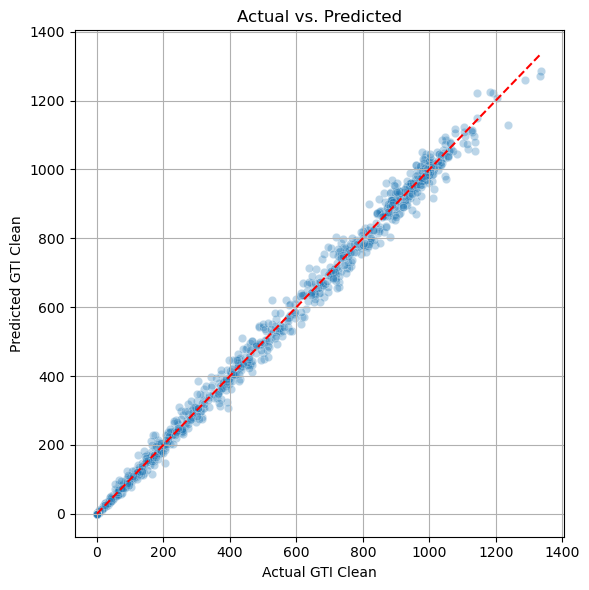

In [20]:
# === 12. Actual vs Predicted Plot ===
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual GTI Clean")
plt.ylabel("Predicted GTI Clean")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


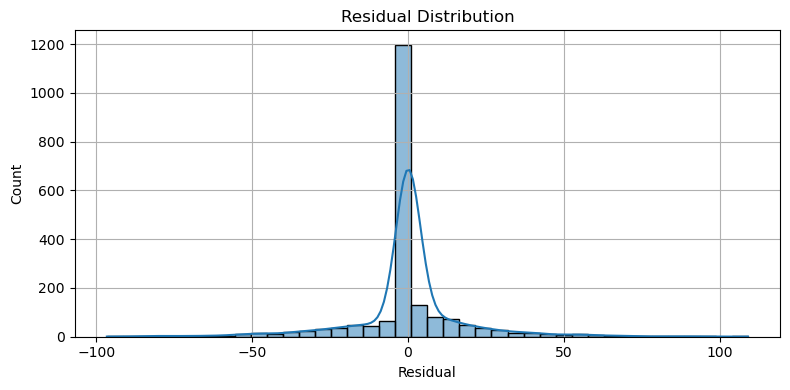

In [21]:
# === 13. Residual Plot ===
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()